Using device: cuda
  - Parameters: 77,243
[Physics*] Epoch 025/150 | Train Acc=97.57% | CE=0.2929 | Phys=0.3102 (λ_total=0.080) | Total=0.3177 || Test F1=0.9503 | Test Acc=95.05% (Best F1=0.9618, Best Acc=96.13%)
[Physics*] Epoch 050/150 | Train Acc=99.49% | CE=0.2569 | Phys=0.2961 (λ_total=0.080) | Total=0.2806 || Test F1=0.9712 | Test Acc=97.12% (Best F1=0.9752, Best Acc=97.49%)
[Physics*] Epoch 075/150 | Train Acc=99.75% | CE=0.2488 | Phys=0.2909 (λ_total=0.080) | Total=0.2720 || Test F1=0.9756 | Test Acc=97.52% (Best F1=0.9783, Best Acc=97.79%)
[Physics*] Epoch 100/150 | Train Acc=99.88% | CE=0.2454 | Phys=0.2878 (λ_total=0.080) | Total=0.2684 || Test F1=0.9782 | Test Acc=97.83% (Best F1=0.9820, Best Acc=98.17%)
[Physics*] Epoch 125/150 | Train Acc=99.90% | CE=0.2439 | Phys=0.2866 (λ_total=0.080) | Total=0.2668 || Test F1=0.9723 | Test Acc=97.22% (Best F1=0.9820, Best Acc=98.17%)
[Physics*] Epoch 150/150 | Train Acc=99.93% | CE=0.2429 | Phys=0.2862 (λ_total=0.080) | Total=0.2658 ||

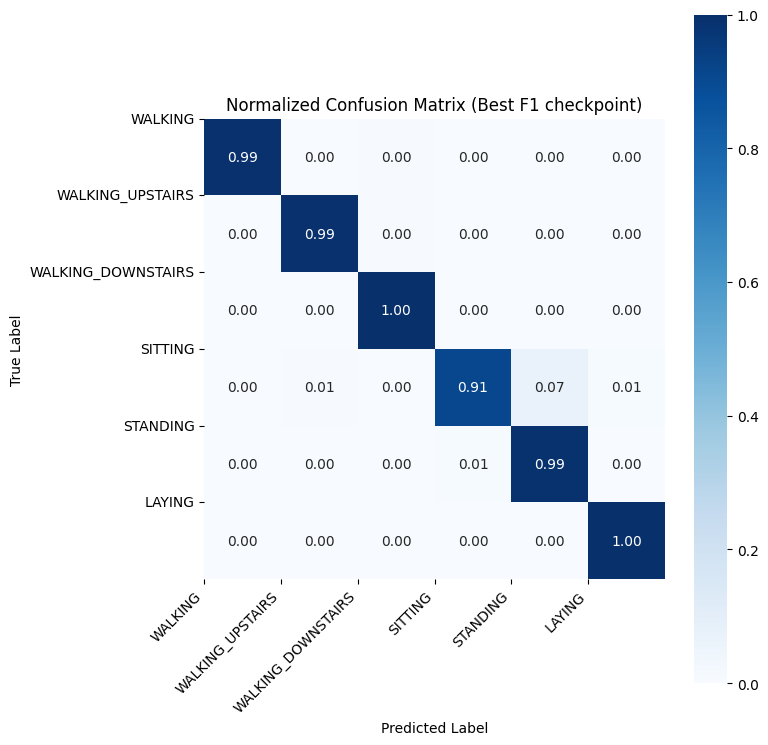


              precision    recall  f1-score   support

           0     1.0000    0.9940    0.9970       496
           1     0.9915    0.9936    0.9926       471
           2     0.9906    1.0000    0.9953       420
           3     0.9868    0.9124    0.9481       491
           4     0.9377    0.9906    0.9634       532
           5     0.9908    1.0000    0.9954       537

    accuracy                         0.9817      2947
   macro avg     0.9829    0.9818    0.9820      2947
weighted avg     0.9822    0.9817    0.9815      2947



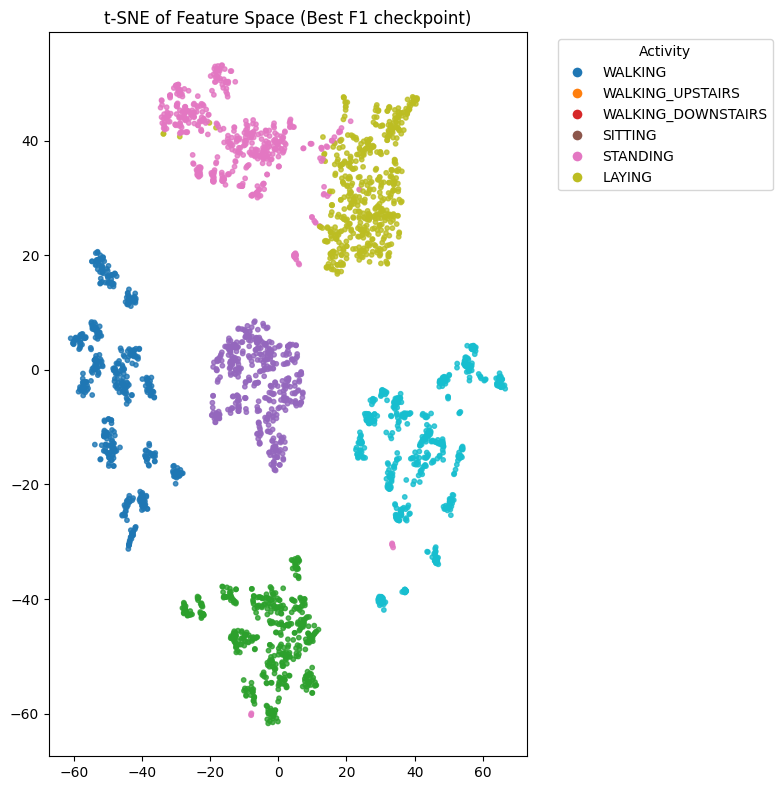

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import time
import random
import math
from collections import deque
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import f1_score    

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# UCI-HAR 데이터 로드 
# ========================
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        base = Path(data_path) / split
        signals = []
        for sensor in ['body_acc', 'body_gyro', 'total_acc']:
            for axis in ['x', 'y', 'z']:
                file = base / 'Inertial Signals' / f'{sensor}_{axis}_{split}.txt'
                signals.append(np.loadtxt(file))

        self.X = np.stack(signals, axis=-1)
        self.y = np.loadtxt(base.parent / split / f'y_{split}.txt').astype(int) - 1

        try:
            self.subjects = np.loadtxt(base.parent / split / f'subject_{split}.txt').astype(int)
        except:
            self.subjects = np.ones(len(self.y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.LongTensor([self.y[idx]])[0],
                self.subjects[idx])

# ========================
# 🔥 Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features
        # 기존 physics_head 유지(원시 acc/gyro 회귀가 필요하면 사용)
        self.physics_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 6)
        )
        # ✅ 중력 방향 예측 헤드 추가 (타임스텝별 3D, 후단에서 unit_norm)
        self.gravity_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

    def forward(self, x, return_physics=False, return_gravity=False):
        x = x.transpose(1, 2)
        x_feat = self.input_proj(x)
        x_feat = F.gelu(self.large_kernel_conv(x_feat))
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = F.gelu(self.final_large_kernel(x_feat))
        if self.use_se:
            x_feat = self.se(x_feat)

        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        outs = [logits]
        if return_gravity or return_physics:
            seq_feat = x_feat.transpose(1, 2)  # (B,T,C)
        if return_gravity:
            gvec = self.gravity_head(seq_feat)   # (B,T,3)
            outs.append(gvec)
        if return_physics:
            phys = self.physics_head(seq_feat)   # (B,T,6)
            outs.append(phys)

        return tuple(outs) if len(outs) > 1 else outs[0]


# ========================
# '물리 손실' 함수 
# ========================
def fir_lpf_hann_bt3(x, K=31):
    """
    x: (B,T,3)  -> a_lp, a_hp (둘 다 (B,T,3))
    간단 Hann 창 평균 기반 LPF. HPF = x - LPF
    """
    assert x.dim() == 3 and x.size(-1) == 3
    B, T, C = x.shape
    xc = x.transpose(1, 2)  # (B,3,T)
    w = torch.hann_window(K, dtype=xc.dtype, device=xc.device)
    w = (w / w.sum()).view(1,1,-1).expand(C,1,-1)  # (3,1,K)
    a_lp = F.conv1d(xc, w, padding=K//2, groups=C).transpose(1, 2)
    a_hp = x - a_lp
    return a_lp, a_hp

def unit_norm(v, eps=1e-8):
    return v / (v.norm(dim=-1, keepdim=True) + eps)

def diff1(x):
    # x: (B,T,D) -> same shape with zero-pad at t=0
    d = x[:, 1:] - x[:, :-1]
    pad = torch.zeros(x.size(0), 1, x.size(2), device=x.device, dtype=x.dtype)
    return torch.cat([pad, d], dim=1)


@torch.no_grad()
def estimate_dt_from_freq(default_dt=1/50):
    # UCI-HAR≈50Hz, MHEALTH≈50Hz, WISDM≈20Hz, PAMAP2≈100Hz
    return default_dt

def physics_loss_upgraded(
    X_raw,          # (B,T,9): [:,:,:3]=acc, [:,:,3:6]=gyro
    g_pred,         # (B,T,3): gravity unit vector (모델 예측)
    lambdas,        # dict: 각 항 가중치
    params          # dict: 하이퍼파라미터(tau_w,tau_a,alpha_lp,alpha_comp,win_mean,dt,g0)
):
    acc = X_raw[:, :, 0:3]
    gyro = X_raw[:, :, 3:6]
    eps = 1e-8

    # 1) LPF로 중력후보, HPF로 동적성분
    a_lp, a_hp = fir_lpf_hann_bt3(acc, K=params.get('K', 31))
    g_from_acc = unit_norm(a_lp, eps=eps)

    # 2) 게이팅: 정적/완만 구간만 신뢰
    tau_w = params.get('tau_w', 1.0)
    tau_a = params.get('tau_a', 0.5)
    gate = ((gyro.norm(dim=-1) < tau_w) & (a_hp.norm(dim=-1) < tau_a)).float()  # (B,T)

    # 3) g_pred 정규화
    g_pred = unit_norm(g_pred, eps=eps)

    # 4) 각 항 계산
    # (a) 방향 정렬 (LPF(acc)와 정렬)
    cos_sim = (g_from_acc * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)
    L_grav = torch.acos(cos_sim).mean()

    # (b) 중력 크기 (정규화된 입력이면 g0≈1.0)
    g0 = params.get('g0', 1.0)
    L_gmag = (gate * (acc.norm(dim=-1) - g0).pow(2)).mean()

    # (c) 보완필터 잔차: g_comp vs g_pred
    alpha_c = params.get('alpha_comp', 0.97)
    dt = params.get('dt', estimate_dt_from_freq())
    g_prev = torch.roll(g_pred, shifts=1, dims=1)
    g_gyro = unit_norm(g_prev - dt * torch.cross(gyro, g_prev, dim=-1), eps=eps)
    g_acc  = unit_norm(acc, eps=eps)
    g_comp = unit_norm(alpha_c * g_gyro + (1 - alpha_c) * g_acc, eps=eps)
    L_comp = torch.acos((g_comp * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)).mean()

    # (d) 자이로 바이어스(창 평균≈0) & (e) 스무딩(jerk/ω̇)
    win = params.get('win_mean', 16)
    gyro_m = fir_lpf_hann_bt3(gyro, K=max(3, 2* (win//2)+1))[0]  # 창 평균 대용
    L_bias = (gate * gyro_m.pow(2).sum(dim=-1)).mean()
    da = diff1(acc);  dw = diff1(gyro)
    L_smooth = (da.pow(2).sum(dim=-1) + dw.pow(2).sum(dim=-1)).mean()

    # (f) 분해 일관성: a_total = a_body + g0*ĝ → a_body 창 평균이 0 근처
    a_body = acc - g0 * g_pred
    a_body_m = fir_lpf_hann_bt3(a_body, K=max(3, 2* (win//2)+1))[0]  # 로우패스=윈도 평균
    L_split = a_body_m.norm(dim=-1).mean()

    # (g) 미분운동학: dg/dt ≈ -ω×g
    dg = diff1(g_pred) / max(dt, 1e-3)
    w_cross_g = torch.cross(gyro, g_pred, dim=-1)
    L_pinn = (dg + w_cross_g).pow(2).sum(dim=-1).mean()

    L = (
        lambdas.get('grav', 0.10)   * L_grav  +
        lambdas.get('gmag', 0.05)   * L_gmag  +
        lambdas.get('comp', 0.10)   * L_comp  +
        lambdas.get('bias', 0.02)   * L_bias  +
        lambdas.get('smooth', 0.02) * L_smooth+
        lambdas.get('split', 0.05)  * L_split +
        lambdas.get('pinn', 0.03)   * L_pinn
    )

    stats = dict(grav=L_grav.item(), gmag=L_gmag.item(), comp=L_comp.item(),
                 bias=L_bias.item(), smooth=L_smooth.item(),
                 split=L_split.item(), pinn=L_pinn.item())
    return L, stats


# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"


# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, epochs=50, lambda_phys=0.05, log_every=1):
    """
    lambda_phys: 총 물리손실 스케일 (각 항 상대가중치는 내부 lambdas)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # 상대 가중치 (스타팅 포인트)
    base_lambdas = dict(grav=0.10, comp=0.12, split=0.05, gmag=0.05, bias=0.02, smooth=0.02, pinn=0.03)
    # 하이퍼 (데이터 표준화/주파수에 맞게 조정)
    params = dict(
        tau_w=1.0, tau_a=0.5, alpha_comp=0.97,
        win_mean=16, dt=estimate_dt_from_freq(), g0=1.0, K=31
    )

    best_f1 = best_acc = 0.0
    history = {"train_ce": [], "train_phys": [], "train_total": [], "test_acc": [], "test_f1": []}

    warm_epochs = 15
    best_state = None
    best_eval_cache = None

    for epoch in range(1, epochs + 1):
        model.train()
        ce_sum = phys_sum = total_sum = 0.0
        correct = total = 0

        # warm-up 스케일: 초반엔 λ_phys를 선형 증가
        if epoch <= warm_epochs:
            phys_scale = lambda_phys * (epoch / warm_epochs)
        else:
            phys_scale = lambda_phys

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # ✅ gravity_head까지 함께 사용
            logits, gvec, _ = model(X, return_physics=True, return_gravity=True)

            loss_ce = F.cross_entropy(logits, y, label_smoothing=0.05)

            # ✅ 업그레이드 물리손실
            L_phys, stats = physics_loss_upgraded(X, g_pred=gvec, lambdas=base_lambdas, params=params)

            loss = loss_ce + phys_scale * L_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            ce_sum += loss_ce.item(); phys_sum += L_phys.item(); total_sum += loss.item()
            preds = logits.argmax(1); correct += (preds == y).sum().item(); total += y.size(0)

        scheduler.step()

        n_batches = len(train_loader)
        ce_avg, phys_avg, total_avg = ce_sum/n_batches, phys_sum/n_batches, total_sum/n_batches
        train_acc = 100.0 * correct / total

        # ===== 평가 =====
        model.eval()
        test_correct = test_total = 0
        all_preds, all_y = [], []
        all_feats = []

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)

                # ✅ 학습 경로와 동일하게 feature 추출 → pooled 확보
                feats = model.input_proj(X.transpose(1, 2))
                feats = model.large_kernel_conv(feats)
                feats = F.gelu(feats)
                for block in model.tcn_blocks:
                    feats = block(feats)
                feats = model.final_large_kernel(feats)
                feats = F.gelu(feats)
                if model.use_se:
                    feats = model.se(feats)
                pooled = F.adaptive_avg_pool1d(feats, 1).squeeze(-1)
                pooled = model.norm_final(pooled)

                logits = model.head(pooled)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())
                all_feats.append(pooled.cpu().numpy())     # ✅ 추가

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(6)), average='macro', zero_division=0)
        best_acc = max(best_acc, test_acc)

        if test_f1 > best_f1 + 1e-9:
            best_f1 = test_f1
            best_acc = max(best_acc, test_acc)
            # CPU 텐서로 깊은 복사
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            # ✅ 베스트 시점 캐시 저장
            best_eval_cache = {
                "y":     np.array(all_y, dtype=np.int64),
                "preds": np.array(all_preds, dtype=np.int64),
                "feats": np.concatenate(all_feats, axis=0)  # (N, D)
            }

        history["train_ce"].append(ce_avg); history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg); history["test_acc"].append(test_acc); history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics*] Epoch {epoch:03d}/{epochs} | Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ_total={phys_scale:.3f}) | "
                  f"Total={total_avg:.4f} || Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history, best_state, best_eval_cache  



# ========================
# 시각화 함수
# ========================
def plot_results(results_dict):
    print(f"{'Model':<35} | {'Best Test F1':>25} | {'Best Test Acc (%)':>25}")
    print("-" * 89) 
    
    # 딕셔너리에서 F1과 Acc를 모두 꺼내서 출력
    for name, metrics in results_dict.items():
        print(f"{name:<35} | {metrics['f1']:>25.4f} | {metrics['acc']:>25.2f}")
    print("-" * 89)
    print("="*90)

def plot_confusion_and_tsne_from_cache(all_y, all_preds, all_feats, ACTIVITY_LABELS=None, save_prefix="results"):
    # Confusion Matrix
    cm = confusion_matrix(all_y, all_preds, normalize='true')
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True)
    plt.xlabel("Predicted Label"); plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix (Best F1 checkpoint)")
    if ACTIVITY_LABELS is not None:
        plt.xticks(ticks=np.arange(len(ACTIVITY_LABELS)), labels=ACTIVITY_LABELS, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(ACTIVITY_LABELS)), labels=ACTIVITY_LABELS, rotation=0)
    plt.tight_layout()
    plt.show()

    # Report
    print("\n" + classification_report(all_y, all_preds, digits=4, zero_division=0))

    # t-SNE (캐시된 pooled feature 사용)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_emb = tsne.fit_transform(all_feats)

    plt.figure(figsize=(8,8))
    scatter = plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=all_y, cmap='tab10', s=10, alpha=0.8)
    plt.title("t-SNE of Feature Space (Best F1 checkpoint)")
    if ACTIVITY_LABELS is not None:
        handles = [plt.Line2D([], [], marker='o', color='w', label=lbl,
                              markerfacecolor=scatter.cmap(i/len(ACTIVITY_LABELS)), markersize=8)
                   for i,lbl in enumerate(ACTIVITY_LABELS)]
        plt.legend(handles=handles, title="Activity", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()


# ========================
# 메인 실행 함수
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Physics/data'

    try:
        train_ds = UCIHARDataset(data_path, split='train')
        test_ds = UCIHARDataset(data_path, split='test')
    except FileNotFoundError:
        print(f"Error: 데이터셋을 찾을 수 없습니다. 'data_path' 변수를 수정하세요.")
        print(f"현재 경로: {data_path}")
        return

    def compute_train_stats(ds):
        # ds.X: numpy (N, T, C)
        X = torch.from_numpy(ds.X)             # (N, T, 9) float64일 수 있음
        X = X.float()
        mean = X.mean(dim=(0,1), keepdim=True) # (1,1,C)
        std  = X.std(dim=(0,1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(train_ds)

    def make_loaders(train_ds, test_ds, mean, std, batch_size=64, seed=42):
        def collate_norm(batch):
            X, y, s = zip(*batch)
            X = torch.stack(X, dim=0).float()
            X = (X - mean) / std
            y = torch.tensor(y, dtype=torch.long)
            s = torch.tensor(s, dtype=torch.long)
            return X, y, s

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_ds, batch_size=batch_size, shuffle=True,
            generator=g, num_workers=0, drop_last=True,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        test_loader = DataLoader(
            test_ds, batch_size=batch_size, shuffle=False,
            num_workers=0, drop_last=False,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        return train_loader, test_loader
    
    EPOCHS = 150 
    results = {} 
    
    # ---
    # Full Model
    # ---
    set_seed(42)
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    model3 = PhysicsModernTCNHAR( 
        input_dim=9, hidden_dim=64, n_layers=3, 
        n_classes=6,
        kernel_sizes=[3, 7], 
        large_kernel=19, 
        dropout=0.1,
        use_se=True        
    ).to(device)
    print(f"  - Parameters: {get_n_params(model3)}")
    f1, acc, hist, best_state, best_eval = train_physics(model3, train_loader, test_loader, device,
                                      epochs=EPOCHS, lambda_phys=0.08, log_every=25) 
    results['Full Model'] = {'f1': f1, 'acc': acc}

    plot_results(results)

    if best_state is not None:
        model3.load_state_dict(best_state)

    ACTIVITY_LABELS = [
        "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
        "SITTING", "STANDING", "LAYING"
    ]
    plot_confusion_and_tsne_from_cache(best_eval["y"], best_eval["preds"], best_eval["feats"], ACTIVITY_LABELS)

if __name__ == '__main__':
    main()
